# Мои попытки решить задачу классфикации с помошью нейронной сети

In [1]:
import numpy as np
from data_loader import load_data

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from common import *

import funs_params as fp

# Загрузка и подготовка данных для классификации

Загрузка

In [2]:
X, Y = load_data("2dim_data_for_nn.csv")

Подготовка тензоров

In [3]:
X_tens = torch.tensor(X.astype('float32'))
Y_tens = torch.tensor(Y.reshape(len(Y),1).astype('float32'))

# Запись нейронной сети

In [4]:
class SimpleNet(nn.Module):

    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(2, 2)
        self.fc2 = nn.Linear(2, 1)

        self.fc1.weight = \
        torch.nn.parameter.Parameter(torch.tensor([[-1.8193, 4.6818], [-5.7335, 2.2301]]))
        self.fc2.weight = \
        torch.nn.parameter.Parameter(torch.tensor([[-3.3749, -5.6865]]))
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

simple_net = SimpleNet()

# Оптимизатор

In [5]:
optimizer = optim.Adam(simple_net.parameters(), lr=0.001)

# Функция потерь

In [6]:
loss_fn = torch.nn.MSELoss()

# Пробуем немного поучить нашу сетку

Первая запись обучающего алгоритма

In [7]:
print('layer 1')
print(simple_net.fc1.weight)
print(simple_net.fc1.bias)
print('layer 2')
print(simple_net.fc2.weight)
print(simple_net.fc2.bias)

for t in range(10000):
    predict = simple_net(torch.tensor(X.astype('float32')))
    loss = loss_fn(predict, Y_tens)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print('layer 1')
print(simple_net.fc1.weight)
print(simple_net.fc1.bias)
print('layer 2')
print(simple_net.fc2.weight)
print(simple_net.fc2.bias)

layer 1
Parameter containing:
tensor([[-1.8193,  4.6818],
        [-5.7335,  2.2301]], requires_grad=True)
Parameter containing:
tensor([-0.0699, -0.3515], requires_grad=True)
layer 2
Parameter containing:
tensor([[-3.3749, -5.6865]], requires_grad=True)
Parameter containing:
tensor([-0.1819], requires_grad=True)
layer 1
Parameter containing:
tensor([[ -1.9267,   7.5119],
        [-12.9543,   2.5174]], requires_grad=True)
Parameter containing:
tensor([-2.9442,  1.5617], requires_grad=True)
layer 2
Parameter containing:
tensor([[ -8.6777, -14.9904]], requires_grad=True)
Parameter containing:
tensor([3.8926], requires_grad=True)


In [8]:
# сумматорная функция ReLU нейрона
# предполагается, что X - np.array()
sum_fun = lambda X: \
    torch.matmul(simple_net.fc1.weight, torch.tensor(X.astype('float32'))) +\
    simple_net.fc1.bias

# Проверка качества

In [9]:
simple_net.fc1.weight

Parameter containing:
tensor([[ -1.9267,   7.5119],
        [-12.9543,   2.5174]], requires_grad=True)

In [10]:
probs_hat = simple_net(torch.tensor(X.astype('float32'))).detach().numpy()
p_bar = get_p_bar(Y, probs_hat)

In [11]:
is_correct_pred = ((probs_hat > p_bar).ravel() == Y)

sum(is_correct_pred)

599

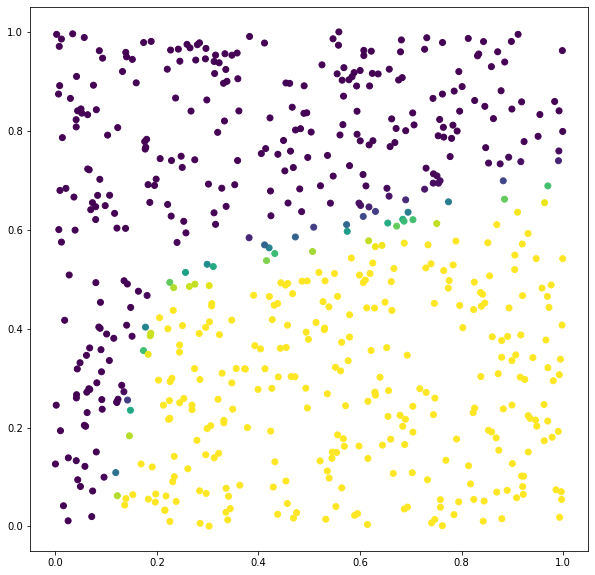

In [12]:
plt.figure(figsize = [10,10])
plt.scatter(X[:,0], X[:,1],c = probs_hat)

# Визуализация заложенных мной закономерностей и того как нейронная сеть их отловила

Вычисляем значения сумматорных функций для различных наблюдений и получение массива, который для каждой записи покажет какие из ReLU нейронов пропускают сигнал.

In [13]:
sum_f_values = \
    (simple_net.fc1.weight.detach().numpy().dot(X.transpose()) +\
     simple_net.fc1.bias.detach().numpy().reshape(2,1)).transpose()

ReLU_decisions = (sum_f_values > 0)

### Отрисовка

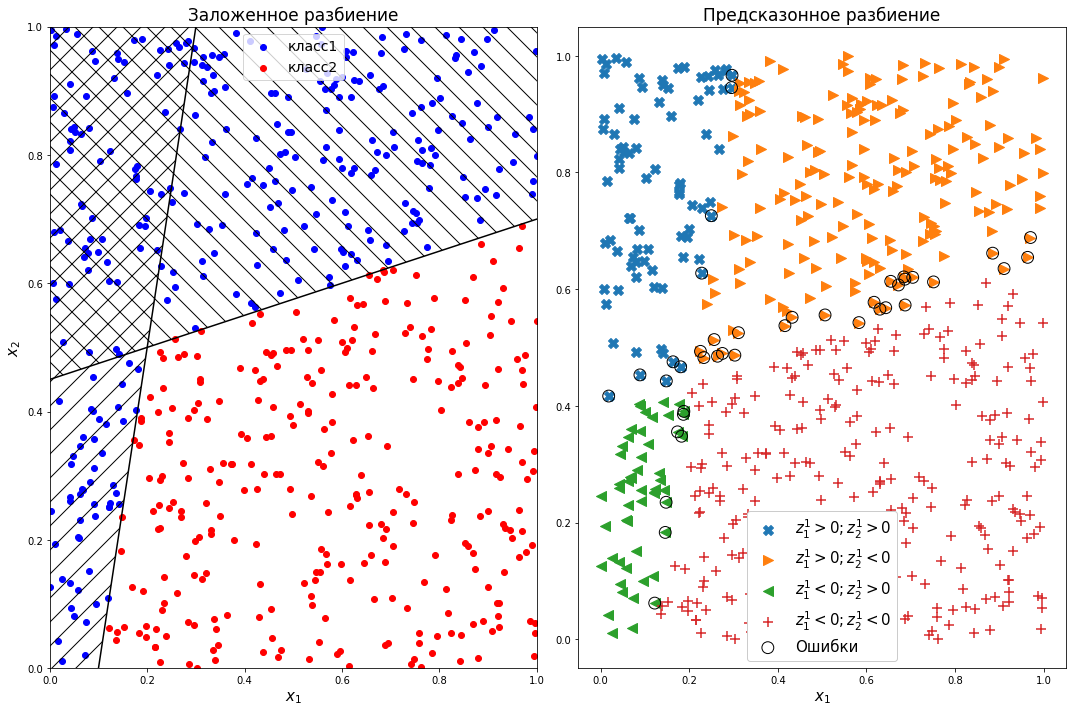

In [42]:
fig = plt.figure(figsize = [15,10])


plt.subplot(121)

line1_x = [-fp.a/fp.a1, -(fp.a+fp.a2)/fp.a1]
line2_y = [-fp.b/fp.b2, -(fp.b+fp.b1)/fp.b2]


# точки
draw_my_scatter(
    X[:,0], X[:,1], Y
)
# площади
plt.fill_between([0] + line1_x, [0, 0, 1], [1]*3,  hatch = '/', alpha = 0)
plt.fill_between([0,1], line2_y, [1,1],  hatch = '\\', alpha = 0)
# дискриминирующие линии
plt.plot(line1_x, [0, 1], 'black')
plt.plot([0,1], line2_y, 'black')


plt.title('Заложенное разбиение', fontsize = 17)
plt.margins(x = 0, y = 0)

plt.subplot(122)

def groups_plot(condition, **kawargs):
    plt.scatter(X[:,0][condition], X[:,1][condition], **kawargs)   

# разбиения маркерами
groups_plot(ReLU_decisions[:,0] & ReLU_decisions[:,1], marker = 'X', s = 100)
groups_plot(ReLU_decisions[:,0] & np.invert(ReLU_decisions[:,1]), marker = '>', s = 100)
groups_plot(np.invert(ReLU_decisions[:,0]) & ReLU_decisions[:,1], marker = '<', s = 100)
groups_plot(np.invert(ReLU_decisions[:,0] | ReLU_decisions[:,1]), marker = '+', s = 100)

# ошибки разбиений
cond1 = \
    (fp.a1*X[:,0] + fp.a2*X[:,1] + fp.a > 0) &\
    ReLU_decisions[:,1]
cond2 = \
    (fp.b1*X[:,0] + fp.b2*X[:,1] + fp.b > 0) &\
    ReLU_decisions[:,0]
plt.scatter(X[cond1,0], X[cond1,1], facecolors='none', edgecolors='black', s = 140)
plt.scatter(X[cond2,0], X[cond2,1], facecolors='none', edgecolors='black', s = 140)


plt.title("Предсказонное разбиение", fontsize = 17)
plt.xlabel("$x_1$", fontsize = 15)

plt.legend([
    "$z_1^1>0;z_2^1>0$",
    "$z_1^1>0;z_2^1<0$",
    "$z_1^1<0;z_2^1>0$",
    "$z_1^1<0;z_2^1<0$",
    "Ошибки"
], fontsize = 15,  framealpha = 1)

fig.tight_layout()
plt.savefig('pictures/non_linear_for_nn.png')